# 自动驾驶-汽车检测
这一节学习物体检测使用强大的YOLO模型。使用物体检测到汽车检测，以及处理编辑框。

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


## 1. 问题描述
正在构建一个汽车驾驶系统，作为这个项目里最关键的一步，第一个想要构建的就是汽车探测系统。为了收集数据们必须使用汽车前面的摄像头，会每几秒就拍一张前面路上的照片。

现在你已经聚集了很多的图片并且做好标记了，画出边界框了。
![](https://upload-images.jianshu.io/upload_images/1779926-424338808c404ec9.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

如果你有80个类别需要YOLO去识别，那么可以在最后直接用一个数字来表示类别，也可以使用一个80维的向量。在这节任务中，我们会用到两种表示，这取决于是否更方便。学习YOLO工作原理，将YOLO运用到汽车检测上。因为YOLO模型的训练计算代价特别大。所以会加载一个预先训练好的参数。

## 2. YOLO
YOLO(you only look once)是一个比较流行的算法，因为有很高的正确率，并且只需要一次前向传播就能通过网络进行预测，在非最大值一直之后，就能输出识别号的物体以及边框界。

### 2.1 模型细节
首先需要知道：
1. 输入时每个图像小堆，维度为(m,608,608,3)
2. 输出是边界框和识别的类标的列表。每一个边界框使用6个数字表示 ，$(p_c, b_x, b_y, b_h, b_w, c)$，如果把c扩展为80维向量，那么每个边界框就要用85个数字去表示。

我们使用5个anchor box，那么看到yolo架构如下，IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85)，强调最后得到的维度是(m,19,19,5,85)。

<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

因为我们使用了5个anchor box，，每一个19\*19的分类结果都将编码成5个盒子，anchor box仅仅用它们自己的高和宽来定义。

简单的说，我们一般会把shape (19, 19, 5, 85) 最后的两个维度平展开来进行编码，所以最deep cnn输出的是（19,19,425）。

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>


现在对于每个盒子（5个anchor box）都会进行下面类似的运算，来说明一个盒子里面是否有东西存在，以及存在的概率和更有可能的类别。对于一个85维的向量，Pc代表是否存在物体，所以使用Pc乘以最后80个每种类别的概率，最后取最大值，即表示最后预测出来是否有物体以及对应类标的最大概率。中间的四个数，即表示盒子的位置。


Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes). 
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u> **Figure 5** </u>: Each of the 19x19 grid cells colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 

Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> **Figure 6** </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

因为我们最后模型可能会测出19*19*5个框，所以我们只画出最高概率的框，但是仍然还是有很多，并且我们只想要画出那么几个关于探测到物体的框，为了达到这个目的，就需要使用非最大值抑制。有下面这些步骤：
1. 抛弃那些小概率边框，意味着这个边框里面可能并没有检测到物体
2. 选择几个相互重叠的检测到一样物体中的一个

### 2.2 在类别分数上使用一个阈值来进行过滤
这里是使用一个阈值来过滤那些边框算出来概率值比较小的，可能没有检测到物体的边框。这个模型总共会输出19\*19\*5\*85个数，每个box都使用85个数来表示，将(19,19,5,85) (or (19,19,425)) 维度的张亮重新排列成下面这些变量，会使得计算比较方便：
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.


**Exercise**: Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4. The following code may help you choose the right operator: 
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b # shape of c will be (19*19, 5, 80)
```
2. For each box, find:
    - the index of the class with the maximum box score ([Hint](https://keras.io/backend/#argmax)) (Be careful with what axis you choose; consider using axis=-1)
    - the corresponding box score ([Hint](https://keras.io/backend/#max)) (Be careful with what axis you choose; consider using axis=-1)
3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep. 
4. Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep. ([Hint](https://www.tensorflow.org/api_docs/python/tf/boolean_mask))

Reminder: to call a Keras function, you should use `K.function(...)`.


In [3]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence*box_class_probs
    """
    这一步，使用了Pc*分数，而不是直接使用80个类别分数进行选择的原因是，有的Pc=0，那么计算出来的那80个答案将是毫无意义的，使用0乘了之后，后面方便过滤掉
    """
    ### END CODE HERE ###
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores,axis=-1)
    """
    box_classes返回的值最大分数值的索引，也就是最后确定最大可能是第几类  Returns the index of the maximum value along an axis
    """
    box_class_scores = K.max(box_scores,axis=-1,keepdims=False)
    """
    box_class_scores是得到最大分数值，就是确定在80类里面，确定是最大概率的那一类的分数是多少 Maximum value in a tensor.
    """
    ### END CODE HERE ###
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    """
    对80个类别进行选最大值之后，那么分别就有19*19*5个数了，那个5的意思是有5个anchor box，下面就看这些盒子的概率值是否超过某一阈值，超过即留下
    """
    filtering_mask = box_class_scores >= threshold
    ### END CODE HERE ###
    
    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    """
    将上一步选择好的面具分别罩在经过一轮取最大类别之后的关于分数，关于边界，以及便于类别的矩阵上，留下符合条件的边框
    这里的面具的维度是（19*19*5），而box_class_scores，boxes，box_classes的维度都是（19*19*5）
    """
    scores = tf.boolean_mask(box_class_scores ,filtering_mask)
    boxes = tf.boolean_mask(boxes ,filtering_mask)
    classes = tf.boolean_mask(box_classes ,filtering_mask)
    ### END CODE HERE ###
    
    return scores, boxes, classes
    """
    最后返回过滤之后的选好类别的，以及大于阈值符合条件的边框，scores里面是分数，boxes是对应的边界位置，classes是类别
    """

In [4]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


### 2.3 非最大值抑制（Non-max suppression） NMS
上面所做的工作只是选出了可能有物体存在的边框，以及对这些留下来的边框的类别进行记录，但是有可能很多都表示的一个物体，所以接下面我们要使用非最大值抑制对几个表示同一个物体的边框进行清理，最后留下最大可能包含物体的边框。

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 7** </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 8** </u>: Definition of "Intersection over Union". <br> </center></caption>

**Exercise**: Implement iou(). Some hints:
- In this exercise only, we define a box using its two corners (upper left and lower right): (x1, y1, x2, y2) rather than the midpoint and height/width.
- To calculate the area of a rectangle you need to multiply its height (y2 - y1) by its width (x2 - x1)
- You'll also need to find the coordinates (xi1, yi1, xi2, yi2) of the intersection of two boxes. Remember that:
    - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes
    
In this code, we use the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) the lower-right corner. 

In [5]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2

    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    """
    这里计算交集部分，可以说是很巧妙了，无论两个边框的位置如何，交界部分的左上角的坐标永远都是两个边界左上角坐标中最大的那一个
    右下角则是小的那一个，就能根据两个边框的8个坐标值得出交集部分的坐标值
    """
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 5 lines)
    xi1 = np.maximum(box1[0],box2[0])
    yi1 = np.maximum(box1[1],box2[1])
    xi2 = np.minimum(box1[2],box2[2])
    yi2 = np.minimum(box1[3],box2[3])
    inter_area = (yi2 - yi1) * (xi2 - xi1)
    ### END CODE HERE ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union_area = box1_area+box2_area - inter_area
    ### END CODE HERE ###
    
    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area / union_area
    ### END CODE HERE ###

    return iou

In [6]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


在写好了IoU算法，接下来就可以继续实现非最大值抑制了，关键步骤如下：
1. 选择有最大分数的盒子
2. 计算它和其他盒子的重叠度，去掉重叠度大于设置的阈值iou_threshold
3. 回到第一步，继续迭代，直到没有一个更低分数的盒子比选中的盒子低

这些步骤就会去掉那些跟选定的盒子有高度重合的部分的盒子。只有最好的会留下。使用tensorflow实现yolo算法的非最大值抑制，tensorflow里面内置了实现非最大值抑制的实现，所以可以不用自己刚才写的那个方法。

- tf.image.non_max_suppression()
- K.gather()


In [7]:
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    """
    K.variable()函数的用法是实例化一个张量，在这里就是把最大边框数10实例化为一个张量，保存在max_boxes_tensor变量里面
    """
    
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    ### END CODE HERE ###
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices )
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [8]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### 2.4 包装过滤
是时候实现一个函数来保存deep cnn的输出了（编码为19x19x5x85），并且使用上面已经实现了的函数来进行过滤。

注意一个细节，表示一个边框可以通过角的坐标，或者中心坐标以及高和宽，YOLO在这些格式间变化在不同的时间。使用下面的函数：
- boxes = yolo_boxes_to_corners(box_xy, box_wh)
- yolo_filter_boxes()函数中，需要对最大的分数以及不够阈值的边框进行消除，输入的就是一个边框的两个角的坐标等，所以为了适应这个函数，我们需要把中心坐标转化为两个角的坐标。
- boxes = scale_boxes(boxes, image_shape) 这个函数是用来调整框的大小的


yolo网络被用来在608\*608的图片数据上训练。如果你把这些数据在不同大小的图片上测试，比如汽车检测数据集就是720\*1280的图片，这一步可以重新调整框的大小，就可以绘制原来的720\*1280的图片了。boxes一般都是用来存放，19*19*5\*4，存放边框的位置。

In [9]:
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs =yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)    
    """
    这一步就是使用上面说到的函数，是将知道中点和高宽的边框转化为知道两个角的坐标的边框
    """

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs,threshold =score_threshold )
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

    """
    总结一下这里发生了什么，这里我们会得到模型训练的结果，原本是(19*19*5*85)的向量，为了方便后面操作，我们将其分割为（19*19*5*1）的表示确定是够有物体的概率
    以及（19&19*5*4）表示边框的位置，这里用的是中心＋高宽，以及（19*19*5*80）表示分类各自的概率。
    1. 将yolo_output内容取出来放到四个变量里面去
    2. 在过滤器部分，我们使用的是两个角的坐标，所以这里把boxes里面的坐标形式进行调整
    3. 过滤检测物体较低的边框
    4. 因为可能网络调整的图像的像素大小发生变化，这里讲boxes边框位置按照像素大小进行调整
    5. 使用非最大值抑制除去重复边框
    
    最后返回保留下来的不超过总个数的所有边框，分数，以及类标
    """

In [10]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


对yolo算法的总结：
- 输入图片为（608,608,3）
- 输入图片首先经过cnn卷积神经网络，最后得到（19,19,5，85）大小的输出
- 平展最后两个维度，得到（19,19,425）
  - 输入图片的每个格子会产生425个数字
  - 5是对应有5个anchor box
  - 85 = 5 + 80，这里的5代表  (pc ,bx ,by ,bh ,bw)，80代表检测80个类别
- 选择边框：
  - 首先按照分数阈值进行选择
  - 非最大值抑制，处于那些重叠度高表示一个物体的边框
- 最后得到关于yolo算法的最终输出


## 3. 在预训练好的yolo模型上测试图片
在这一部分，将要使用一个预先训练好的模型，并且测试，使用汽车检测数据集。像往常一样，最开始先为计算图创建一个session。

In [11]:
sess = K.get_session()

### 3.1 定义classes，anchors，以及图像的像素大小
我们已经把80类标信息，以及5个anchor box信息放在两个txt文件中了。汽车检测数据集是720\*1280大小的，而我们之前训练的是608\*608大小的。

In [12]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

### 3.2 加载预训练好的模型
训练一个yolo模型需要花很多的时间，并且需要一个相对很大的标记好的有边界框的数据集。现在将要加载keras中已经预先训练好的yolo模型，这个模型存在“yolo.h5”文件中。权重都来自于yolo官方网站，并且使用一个函数就可以转化。

In [2]:
yolo_model = load_model("model_data/yolo.h5")

D:\softpath\Anaconda2\envs\py3\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

在有些计算机上，会看到一些关于Keras的警告信息，不用管。

这个模型将输入数据是（m，608,608,3）的变为（m，19,19,5,85）的输出。

### 3.3 转化模型的输出到可以使用边界框张量
The output of yolo_model is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. The following cell does that for you

In [14]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

### 3.4 过滤边界框

In [15]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

### 3.5 在一张图片上运行计算图
1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>

练习：实现predict()函数，运行计算图测试yolo算法在一张图片上。你将需要运行一个tensorflow的session，来计算scores boxes以及classes。 

用到这个函数：
```python
image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
```
image表示用来画边界框的图片， image_data是用一个numpy来表示矩阵，这会被用来输入到cnn卷积网络里面去。

Important note: when a model uses BatchNorm (as is the case in YOLO), you will need to pass an additional placeholder in the feed_dict {K.learning_phase(): 0}.

In [16]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run([scores,boxes,classes],feed_dict={yolo_model.input:image_data,K.learning_phase():0})
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


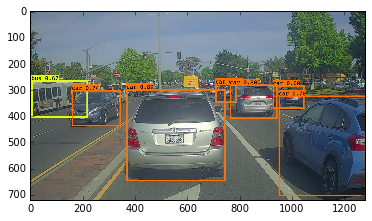

In [23]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

Found 4 boxes for test1.jpg
car 0.61 (1173, 342) (608, 429)
car 0.67 (141, 346) (242, 434)
person 0.69 (609, 350) (608, 531)
car 0.70 (298, 357) (386, 417)


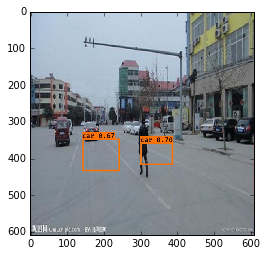

In [27]:
out_scores, out_boxes, out_classes = predict(sess, "test1.jpg")

<font color='blue'>
**What you should remember**:
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN which outputs a 19x19x5x85 dimensional volume. 
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically: 
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise. 

#### 总结
这节任务里面其实我们只是代码操作了如何在一张图片上检测到了n个边界框，使用非最大值抑制的算法选择最后符合条件的边界框，至于这个边界框，以及检测到的物体分类都是yolo模型来完成的，而这个模型是直接从Yolo.h5文件中加载得到的，包括模型的结构，模型的参数，权重等。测试的时候我们是给这模型喂入图片作为输入，根据已有的参数进行predict得到一个（19,19,5,85）的输出，经过对输出的处理以及去掉多余的边框，最后绘制出，符合预期的物体检测结果。

# 题外话-曲折

最近的作业都完成的好曲折啊，要么是模型文件.h5各种自己去到处找，下错，导致报其他错，还以为是代码问题，各种找报错原因，从代码修改，无果。就比如说，做人脸识别的作业。然后做残差网络的时候呢，源代码里面有个地方说，没有axis这个参数，又各种查看tensorflow的版本，看是不是版本问题，来回更换，最后也没有解决，查官方文档，发现后来的tensorflow里面已经没有axis这个参数，而是改成dim，在源码里面修改后，终于成功。

这次的物体检测，yolo模型文件从coursera官网上下的，是对了，然而运行时候，出现python停止运行的问题，以为可能的问题是：1.内存不够，重启，无果。2. tensorflow，keras版本问题，和官方保持一致，无果。3.换台电脑运行，windows10系统，不报python停止运行了，报的另一个错，没有tf.nn.leaky_relu，查官方文档，换版本，最后不报这个这个错了，又报编码的错，继续换报，最后再报同样也是python停止运行。  4. 在coursera官方论坛上发现，很多本地运行这个项目的同学都遇到了这个问题，以上三个问题，其实都一个解决方案，那就是coursera官方下下来的yolo.h5不管用，需要自己训练一个模型出来。至于得到yolo.h5的方法大神提供了。

** If you are using Anaconda on Windows:
1. Download or clone: https://github.com/allanzelener/YAD2K
2. Download and put in "YAD2K" folder: http://pjreddie.com/media/files/yolo.weights
3. Download and put in "YAD2K" folder: https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolo.cfg
4. 把下载下来的yolo.weights和yolo.cfg文件都放入YAD2K文件夹中，cmd进入文件夹，运行下面代码
5. Run: "python yad2k.py yolo.cfg yolo.weights model_data/yolo.h5"
6. If all went well - you will have a new "yolo.h5"model file in "model_data" folder, use it to replace old file in notebook

然而，问题又来了，第3步的链接失效了，那么哪里去找那个yolo.cfg文件。。。这里就学习了一下关于github的使用了，pjreddie表示github上用户名，后面那个是项目名darknet，master表示分支，最后是文件名，进入这个用户的github，找到这个项目早期的关于fixed yolo_v1这个时间点，发现可能是更新了，所以这个文件的链接以及内容后来都修改了，但是回到github上以前那个时间点的项目就能找到正确的文件。最后就可以成功运行了，得到新的yolo.h5文件。。。。。。。当然还有坑，如果是windows10的朋友，keras的一个general_utils文件里面还有个关于windows10纪念版关于文件名斜杠的问题，修改code=,,,这一行代码。最后，没有解决不了的问题，感谢大佬。
![最后训练完成得到yolo.h5](https://upload-images.jianshu.io/upload_images/1779926-930aec2d77d97c7d.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


最后的最后，yolo.h5文件重新训练得到，代码也就跑通了。在本地也能跑了。每次打开jupyter notebook调试都是一番等待，心态崩了。

学会了啥，学会了如何找答案，如何使用github，看大佬手把手教如何解决问题，如何从gihub上下载源码，更改各种包的版本，最后成功运行大佬的代码，得到想要的结果。